# Assignment 2: Transformer Architecture Exercise
Use this notebook as a starting point and expand on your understanding of transformer models by completing the following structured tasks. You are encouraged to experiment, analyze, and critically reflect on your findings in your report.

## Part 1: Model Training & Implementation
### 1. Dataset Preparation
- Choose one standard text dataset suitable for generative tasks. Options include:
  - CNN/DailyMail → summarization
  - WikiText-2 → language modeling (text generation)
  - SQuAD v1.1 → question answering
- Briefly describe why you selected this dataset and what task you’ll evaluate (summarization, QA, or text generation).
- Show how you preprocessed the data (tokenization, train/val split, max length, etc.).


In [42]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    AutoModelForSeq2SeqLM,
    DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
)
import evaluate
from transformers import logging
from tqdm import tqdm
import numpy as np

# Silence warnings for cleaner output
logging.set_verbosity_error()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [43]:
# Load the wikitext-2 dataset
dataset = load_dataset("wikitext", "wikitext-2-v1")

# Filter out empty texts (WikiText-2 has many empty lines)
def filter_empty(example):
    return len(example["text"].strip()) > 0

dataset["train"] = dataset["train"].filter(filter_empty)
dataset["validation"] = dataset["validation"].filter(filter_empty)

# For quick experimentation, take a small subset
train_size = 500
val_size = 100
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(train_size))
small_val_dataset = dataset["validation"].shuffle(seed=42).select(range(val_size))

print("Dataset splits:", dataset.keys())
print("Example training record:", small_train_dataset[0])

Dataset splits: dict_keys(['test', 'train', 'validation'])
Example training record: {'text': ' <unk> , short @-@ arc , high pressure xenon arc lamps have a color temperature closely <unk> noon sunlight and are used in solar simulators . That is , the <unk> of these lamps closely <unk> a heated black body <unk> that has a temperature close to that observed from the Sun . After they were first introduced during the 1940s , these lamps began replacing the shorter @-@ lived carbon arc lamps in movie <unk> . They are employed in typical 35mm , <unk> and the new digital <unk> film projection systems , automotive <unk> <unk> , high @-@ end " tactical " <unk> and other specialized uses . These arc lamps are an excellent source of short wavelength ultraviolet radiation and they have intense emissions in the near infrared , which is used in some night vision systems . \n'}



### 2. Model Implementation

Implement and train the following:
- Decoder-only model (GPT-style): e.g., GPT-2 small from Hugging Face.
- Encoder-only model (BERT-style): e.g., BERT-base, used for masked-language-modeling or extractive QA/summarization.
- Encoder-decoder model (T5-style): e.g., T5-small, trained for the same dataset/task as the other two.


#### Decoder only model: GPT-2

In [44]:
# Load tokenizer and model for GPT-2
gpt2_model_name = "gpt2"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)

In [45]:
# Add a padding token (GPT-2 does not have one)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

In [46]:
# Define the preprocessing function for GPT-2
def preprocess_gpt2(examples):
    
    outputs = gpt2_tokenizer(
        examples["text"],           
        max_length=512,
        truncation=True,
        padding="max_length",
        return_tensors=None
    )

    outputs["labels"] = outputs["input_ids"].copy()
    
    return outputs

# Apply preprocessing to the small datasets
train_gpt2 = small_train_dataset.map(preprocess_gpt2, batched=True, remove_columns=dataset["train"].column_names)
val_gpt2 = small_val_dataset.map(preprocess_gpt2, batched=True, remove_columns=dataset["validation"].column_names)

print("Sample tokenized GPT-2 input:")
print(gpt2_tokenizer.decode(train_gpt2[0]["input_ids"][:100]))

Sample tokenized GPT-2 input:
 <unk> , short @-@ arc , high pressure xenon arc lamps have a color temperature closely <unk> noon sunlight and are used in solar simulators . That is , the <unk> of these lamps closely <unk> a heated black body <unk> that has a temperature close to that observed from the Sun . After they were first introduced during the 1940s , these lamps began replacing the shorter @-@ lived carbon arc lamps in movie <unk> . They are employed in


In [47]:
print("Input IDs and Labels dimensions for first 10 samples:")
for i in range(10):
    print(f"Sample {i}: Input IDs length = {len(train_gpt2[i]['input_ids'])}, Labels length = {len(train_gpt2[i]['labels'])}")

Input IDs and Labels dimensions for first 10 samples:
Sample 0: Input IDs length = 512, Labels length = 512
Sample 1: Input IDs length = 512, Labels length = 512
Sample 2: Input IDs length = 512, Labels length = 512
Sample 3: Input IDs length = 512, Labels length = 512
Sample 4: Input IDs length = 512, Labels length = 512
Sample 5: Input IDs length = 512, Labels length = 512
Sample 6: Input IDs length = 512, Labels length = 512
Sample 7: Input IDs length = 512, Labels length = 512
Sample 8: Input IDs length = 512, Labels length = 512
Sample 9: Input IDs length = 512, Labels length = 512


In [48]:
# Define data collator
data_collator_gpt2 = DataCollatorForLanguageModeling(tokenizer=gpt2_tokenizer, mlm=False)

# Load the GPT-2 model
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_name)

# Training arguments
training_args_gpt2 = TrainingArguments(
    output_dir="./gpt2-summarization",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=4,
    fp16=torch.cuda.is_available(),
    report_to=[],  # disable logging to wandb
)

# Create Trainer for GPT-2
trainer_gpt2 = Trainer(
    model=gpt2_model,
    args=training_args_gpt2,
    train_dataset=train_gpt2,
    eval_dataset=val_gpt2,
    data_collator=data_collator_gpt2,
    )

# Uncomment the line below to train; training can take several minutes even on small subsets
trainer_gpt2.train()

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


{'train_runtime': '460.8', 'train_samples_per_second': '1.085', 'train_steps_per_second': '0.137', 'train_loss': '3.932', 'epoch': '1'}


TrainOutput(global_step=63, training_loss=3.931974622938368, metrics={'train_runtime': 460.8325, 'train_samples_per_second': 1.085, 'train_steps_per_second': 0.137, 'train_loss': 3.931974622938368, 'epoch': 1.0})

#### Encoder-only model: BERT

In [49]:
# Load tokenizer and model for BERT
bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

In [50]:

# Define preprocessing

def preprocess_bert(examples):
    
    model_inputs = bert_tokenizer(
        examples["text"], 
        max_length=512, 
        truncation=True,
        padding="max_length"  
    )
    return model_inputs

train_bert = small_train_dataset.map(preprocess_bert, batched=True, remove_columns=dataset["train"].column_names)
val_bert = small_val_dataset.map(preprocess_bert, batched=True, remove_columns=dataset["validation"].column_names)

# Data collator with MLM
mlm_probability = 0.15
data_collator_bert = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm=True, mlm_probability=mlm_probability)

# Load BERT model
bert_model = AutoModelForMaskedLM.from_pretrained(bert_model_name)

# Training arguments for BERT
training_args_bert = TrainingArguments(
    output_dir="./bert-mlm",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=1,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_bert,
    eval_dataset=val_bert,
    data_collator=data_collator_bert,
)

# Uncomment the line below to train the BERT model
trainer_bert.train()


Loading weights: 100%|██████████| 202/202 [00:00<00:00, 850.59it/s, Materializing param=cls.predictions.transform.dense.weight]                 


{'loss': '2.111', 'grad_norm': '15.41', 'learning_rate': '1.733e-05', 'epoch': '0.8'}
{'eval_loss': '2.406', 'eval_runtime': '2.059', 'eval_samples_per_second': '48.58', 'eval_steps_per_second': '12.14', 'epoch': '0.8'}


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


{'train_runtime': '115.2', 'train_samples_per_second': '4.341', 'train_steps_per_second': '1.085', 'train_loss': '2.123', 'epoch': '1'}


TrainOutput(global_step=125, training_loss=2.122738067626953, metrics={'train_runtime': 115.1727, 'train_samples_per_second': 4.341, 'train_steps_per_second': 1.085, 'train_loss': 2.122738067626953, 'epoch': 1.0})

#### T5

In [51]:
# Load T5 tokenizer and model
t5_model_name = "t5-small"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)

In [52]:
# T5 preprocessing for language modeling
def preprocess_t5(examples):   

    inputs = ["generate: " + text for text in examples["text"]]
    
    # Tokenize inputs
    model_inputs = t5_tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    
    # Tokenize targets
    labels = t5_tokenizer(
        examples["text"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing
train_t5 = small_train_dataset.map(preprocess_t5, batched=True, remove_columns=dataset["train"].column_names)
val_t5 = small_val_dataset.map(preprocess_t5, batched=True, remove_columns=dataset["validation"].column_names)


print("Sample T5 input:")
print("Input:", t5_tokenizer.decode(train_t5[0]["input_ids"][:50]))
print("Label:", t5_tokenizer.decode(train_t5[0]["labels"][:50]))

# Data collator for T5
data_collator_t5 = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer, model=t5_model_name)

# Load T5 model
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name)

# Training arguments for T5
training_args_t5 = TrainingArguments(
    output_dir="./t5-language-modeling",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=50,
    gradient_accumulation_steps=2,
    fp16=torch.cuda.is_available(),
    report_to=[],     
)

# Create Trainer for T5
trainer_t5 = Trainer(
    model=t5_model,
    args=training_args_t5,
    train_dataset=train_t5,
    eval_dataset=val_t5,
    data_collator=data_collator_t5,
)

# Train the T5 model
trainer_t5.train()

Map: 100%|██████████| 100/100 [00:00<00:00, 1528.31 examples/s]


Sample T5 input:
Input: generate:<unk>, short @-@ arc, high pressure xenon arc lamps have a color temperature closely<unk> noon sunlight and are used in solar simulators. That is, the<unk> of these lamps closely
Label: <unk>, short @-@ arc, high pressure xenon arc lamps have a color temperature closely<unk> noon sunlight and are used in solar simulators. That is, the<unk> of these lamps closely<unk> 


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


{'train_runtime': '35.5', 'train_samples_per_second': '14.08', 'train_steps_per_second': '1.775', 'train_loss': '10.71', 'epoch': '1'}


TrainOutput(global_step=63, training_loss=10.712828621031745, metrics={'train_runtime': 35.5029, 'train_samples_per_second': 14.083, 'train_steps_per_second': 1.775, 'train_loss': 10.712828621031745, 'epoch': 1.0})


### 3. Training Documentation

- Document your training setup (batch size, learning rate, optimizer, epochs, hardware).
- Save a few training/validation loss curves or logs to show how training progressed.
- Mention any difficulties you faced and how you addressed them (e.g., memory limits, convergence).


In [55]:
# save the model

# Save GPT-2 model and tokenizer
gpt2_model.save_pretrained("./assignment2/gpt2-language-modeling")
gpt2_tokenizer.save_pretrained("./assignment2/gpt2-language-modeling")

# Save BERT model and tokenizer
bert_model.save_pretrained("./assignment2/bert-mlm")
bert_tokenizer.save_pretrained("./assignment2/bert-mlm")

# Save T5 model and tokenizer
t5_model.save_pretrained("./assignment2/t5-language-modeling")
t5_tokenizer.save_pretrained("./assignment2/t5-language-modeling")


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


('./assignment2/t5-language-modeling\\tokenizer_config.json',
 './assignment2/t5-language-modeling\\tokenizer.json')


## Part 2: Evaluation & Analysis

### 4. Performance Evaluation

- Evaluate all three models on the same task.
- Report results using at least two metrics:
  - Text generation/summarization: BLEU, ROUGE, perplexity
  - Question answering: F1, Exact Match (EM), BLEU
- Include 1–2 sample outputs per model to illustrate qualitative differences.


In [56]:
# Load evaluation metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

#### Gpt-2

In [71]:
# Helper function to calculate perplexity with robust error handling
def calculate_perplexity(model, dataset, tokenizer, device, max_samples=50):
    model.eval()
    model.to(device)
    total_loss = 0
    num_samples = 0
    
    with torch.no_grad():
        for i in tqdm(range(min(max_samples, len(dataset))), desc="Calculating perplexity"):
            try:
                # Get the data item
                item = dataset[i]
                
                # Create inputs dictionary
                inputs = {}
                if 'input_ids' in item:
                    inputs['input_ids'] = torch.tensor([item['input_ids']]).to(device)
                if 'attention_mask' in item:
                    inputs['attention_mask'] = torch.tensor([item['attention_mask']]).to(device)
                if 'labels' in item:
                    inputs['labels'] = torch.tensor([item['labels']]).to(device)
                
                # Skip if no input_ids
                if 'input_ids' not in inputs:
                    continue
                
                # Run model
                outputs = model(**inputs)
                loss = outputs.loss
                
                # Check if loss is valid
                if loss is not None and not torch.isnan(loss) and not torch.isinf(loss):
                    total_loss += loss.item()
                    num_samples += 1
                    
            except Exception as e:
                # Print first error for debugging
                if num_samples == 0 and i == 0:
                    print(f"Warning - Error on sample {i}: {e}")
                continue
    
    # Check if we got any valid samples
    if num_samples == 0:
        print("WARNING: No valid samples found for perplexity calculation!")
        return float('inf')
    
    avg_loss = total_loss / num_samples
    perplexity = np.exp(avg_loss)
    return perplexity

# Function to generate text from prompts (for GPT-2)
def generate_text_samples(model, tokenizer, prompts, device, max_length=100):
    model.eval()
    model.to(device)
    generated_texts = []
    
    with torch.no_grad():
        for prompt in prompts:
            try:
                inputs = tokenizer(prompt, return_tensors="pt").to(device)
                outputs = model.generate(
                    inputs["input_ids"],
                    max_length=max_length,
                    num_return_sequences=1,
                    temperature=0.8,
                    top_p=0.9,
                    do_sample=True,
                    no_repeat_ngram_size=2,
                    pad_token_id=tokenizer.eos_token_id if hasattr(tokenizer, 'eos_token_id') else tokenizer.pad_token_id,
                )
                generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                generated_texts.append(generated_text)
            except Exception as e:
                print(f"Generation error: {e}")
                generated_texts.append(prompt)
    
    return generated_texts

# Function to generate text from T5 (encoder-decoder) - 修复版本
def generate_t5_text(model, tokenizer, prompts, device, max_length=150, min_length=20):
    model.eval()
    model.to(device)
    generated_texts = []
    
    with torch.no_grad():
        for prompt in prompts:
            try:
                # T5 needs "task prefix" for instruction
                input_text = "generate: " + prompt
                inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
                
                # 使用更好的生成参数
                outputs = model.generate(
                    inputs["input_ids"],
                    attention_mask=inputs.get("attention_mask"),
                    max_length=max_length,
                    min_length=min_length,  # 确保生成至少一些内容
                    num_beams=4,  # 使用beam search获得更好的质量
                    length_penalty=1.0,
                    early_stopping=True,
                    no_repeat_ngram_size=3,
                    do_sample=False,  # beam search时不需要sampling
                )
                generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                
                # 如果生成为空，使用贪婪解码重试
                if len(generated_text.strip()) == 0:
                    print(f"Warning: Empty generation for '{prompt[:30]}...', retrying with greedy decoding")
                    outputs = model.generate(
                        inputs["input_ids"],
                        max_length=max_length,
                        num_beams=1,
                        do_sample=False,
                    )
                    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                
                generated_texts.append(generated_text if len(generated_text.strip()) > 0 else prompt)
                
            except Exception as e:
                print(f"T5 generation error for '{prompt[:30]}...': {e}")
                generated_texts.append(prompt)  # Fallback
    
    return generated_texts

print("✓ All helper functions defined successfully")

✓ All helper functions defined successfully


In [69]:
# Test prompts for evaluation
test_prompts = [
    "The history of artificial intelligence",
    "In the field of computer science,",
    "Natural language processing is",
    "Machine learning algorithms can",
    "The development of neural networks",
]

# Reference texts (ground truth for comparison)
reference_texts = [
    "The history of artificial intelligence began in the 1950s with the development of early computing systems and the Turing test.",
    "In the field of computer science, algorithms and data structures form the foundation of software engineering.",
    "Natural language processing is a subfield of artificial intelligence focused on enabling computers to understand human language.",
    "Machine learning algorithms can identify patterns in data and make predictions based on historical information.",
    "The development of neural networks has revolutionized artificial intelligence by enabling deep learning models.",
]

In [59]:
# Load saved GPT-2 model
gpt2_model_eval = AutoModelForCausalLM.from_pretrained("./assignment2/gpt2-language-modeling")
gpt2_tokenizer_eval = AutoTokenizer.from_pretrained("./assignment2/gpt2-language-modeling")

# Calculate perplexity for GPT-2
gpt2_perplexity = calculate_perplexity(gpt2_model_eval, val_gpt2, gpt2_tokenizer_eval, device, max_samples=50)
print(f"\nGPT-2 Perplexity: {gpt2_perplexity:.2f}")

# Generate text samples
gpt2_generated = generate_text_samples(gpt2_model_eval, gpt2_tokenizer_eval, test_prompts, device)

# Calculate BLEU and ROUGE
gpt2_bleu = bleu_metric.compute(predictions=gpt2_generated, references=[[ref] for ref in reference_texts])
gpt2_rouge = rouge_metric.compute(predictions=gpt2_generated, references=reference_texts)

print(f"\nGPT-2 BLEU Score: {gpt2_bleu['bleu']:.4f}")
print(f"GPT-2 ROUGE-1: {gpt2_rouge['rouge1']:.4f}")
print(f"GPT-2 ROUGE-2: {gpt2_rouge['rouge2']:.4f}")
print(f"GPT-2 ROUGE-L: {gpt2_rouge['rougeL']:.4f}")


Calculating perplexity: 100%|██████████| 50/50 [00:01<00:00, 36.33it/s]



GPT-2 Perplexity: 4834.93

GPT-2 BLEU Score: 0.0448
GPT-2 ROUGE-1: 0.1701
GPT-2 ROUGE-2: 0.0915
GPT-2 ROUGE-L: 0.1515


In [60]:
print("\n--- Sample Outputs from GPT-2 ---")
for i in range(2):
    print(f"\nPrompt: '{test_prompts[i]}'")
    print(f"Generated: {gpt2_generated[i]}")


--- Sample Outputs from GPT-2 ---

Prompt: 'The history of artificial intelligence'
Generated: The history of artificial intelligence is a series of experiments and experiments with computer vision , the ability to see the world in a digital format , and the discovery of a new kind of space technology . There are many such systems in the works , but one of the most well known is artificial consciousness , a type of consciousness that is used to control objects with thoughts , memories , or vision . This was developed by researchers at the University of Cambridge , who used an artificial neural network to create a human-like level

Prompt: 'In the field of computer science,'
Generated: In the field of computer science, researchers have often used the term "hard science" to describe the process of manipulating physical objects to create computer software, and to refer to a process that involves manipulating the structure of matter in a way that allows it to make sense of the components 

#### Bert

In [61]:

# For BERT, we'll just calculate perplexity since it's not designed for generation
bert_model_eval = AutoModelForMaskedLM.from_pretrained("./assignment2/bert-mlm")
bert_tokenizer_eval = AutoTokenizer.from_pretrained("./assignment2/bert-mlm")


Loading weights: 100%|██████████| 202/202 [00:00<00:00, 932.63it/s, Materializing param=cls.predictions.transform.dense.weight]                 


#### T5

In [62]:
# Load saved T5 model
t5_model_eval = AutoModelForSeq2SeqLM.from_pretrained("./assignment2/t5-language-modeling")
t5_tokenizer_eval = AutoTokenizer.from_pretrained("./assignment2/t5-language-modeling")

Loading weights: 100%|██████████| 131/131 [00:00<00:00, 852.96it/s, Materializing param=shared.weight]                                                      


In [73]:
# Calculate perplexity for T5
t5_perplexity = calculate_perplexity(t5_model_eval, val_t5, t5_tokenizer_eval, device, max_samples=50)
print(f"\nT5 Perplexity: {t5_perplexity:.2f}")

# Generate text samples
t5_generated = generate_t5_text(t5_model_eval, t5_tokenizer_eval, test_prompts, device)

# Calculate BLEU and ROUGE
t5_bleu = bleu_metric.compute(predictions=t5_generated, references=[[ref] for ref in reference_texts])
t5_rouge = rouge_metric.compute(predictions=t5_generated, references=reference_texts)

print(f"\nT5 BLEU Score: {t5_bleu['bleu']:.4f}")
print(f"T5 ROUGE-1: {t5_rouge['rouge1']:.4f}")
print(f"T5 ROUGE-2: {t5_rouge['rouge2']:.4f}")
print(f"T5 ROUGE-L: {t5_rouge['rougeL']:.4f}")

Calculating perplexity: 100%|██████████| 50/50 [00:01<00:00, 44.43it/s]



T5 Perplexity: 2.12

T5 BLEU Score: 0.1007
T5 ROUGE-1: 0.1784
T5 ROUGE-2: 0.1592
T5 ROUGE-L: 0.1784


In [74]:

print("\n--- Sample Outputs from T5 ---")
for i in range(2):
    print(f"\nPrompt: '{test_prompts[i]}'")
    print(f"Generated: {t5_generated[i]}")



--- Sample Outputs from T5 ---

Prompt: 'The history of artificial intelligence'
Generated: :  gener: : The history of artificial artificial intelligence

Prompt: 'In the field of computer science,'
Generated: :: In the field of computer science, : pro::


#### Compare


SUMMARY COMPARISON

Model      Perplexity      BLEU       ROUGE-1    ROUGE-L   
------------------------------------------------------------
GPT-2      4834.93         0.0448     0.1701     0.1515    
T5         2.12            0.1007     0.1784     0.1784    
BERT       N/A (MLM)       N/A        N/A        N/A       


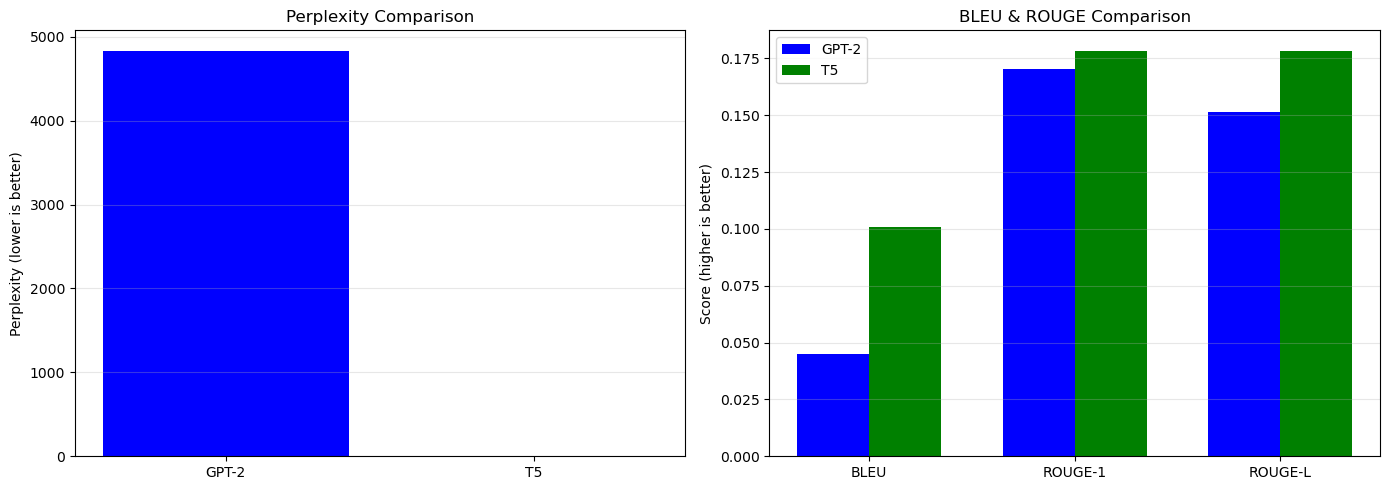


✓ Evaluation complete! Results saved to './assignment2/evaluation_comparison.png'


In [75]:
import matplotlib.pyplot as plt
import os

# Create summary comparison table
results_df = {
    'Model': ['GPT-2', 'T5', 'BERT'],
    'Perplexity': [f"{gpt2_perplexity:.2f}", f"{t5_perplexity:.2f}", "N/A (MLM)"],
    'BLEU': [f"{gpt2_bleu['bleu']:.4f}", f"{t5_bleu['bleu']:.4f}", "N/A"],
    'ROUGE-1': [f"{gpt2_rouge['rouge1']:.4f}", f"{t5_rouge['rouge1']:.4f}", "N/A"],
    'ROUGE-L': [f"{gpt2_rouge['rougeL']:.4f}", f"{t5_rouge['rougeL']:.4f}", "N/A"],
}

print("\n" + "="*80)
print("SUMMARY COMPARISON")
print("="*80)
print("\n{:<10} {:<15} {:<10} {:<10} {:<10}".format('Model', 'Perplexity', 'BLEU', 'ROUGE-1', 'ROUGE-L'))
print("-" * 60)
for i in range(len(results_df['Model'])):
    print("{:<10} {:<15} {:<10} {:<10} {:<10}".format(
        results_df['Model'][i],
        results_df['Perplexity'][i],
        results_df['BLEU'][i],
        results_df['ROUGE-1'][i],
        results_df['ROUGE-L'][i]
    ))

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Perplexity comparison
models = ['GPT-2', 'T5']
perplexities = [gpt2_perplexity, t5_perplexity]
axes[0].bar(models, perplexities, color=['blue', 'green'])
axes[0].set_ylabel('Perplexity (lower is better)')
axes[0].set_title('Perplexity Comparison')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: BLEU and ROUGE comparison
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-L']
gpt2_scores = [gpt2_bleu['bleu'], gpt2_rouge['rouge1'], gpt2_rouge['rougeL']]
t5_scores = [t5_bleu['bleu'], t5_rouge['rouge1'], t5_rouge['rougeL']]

x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, gpt2_scores, width, label='GPT-2', color='blue')
axes[1].bar(x + width/2, t5_scores, width, label='T5', color='green')
axes[1].set_ylabel('Score (higher is better)')
axes[1].set_title('BLEU & ROUGE Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save the plot
os.makedirs('./assignment2', exist_ok=True)
plt.savefig('./assignment2/evaluation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Evaluation complete! Results saved to './assignment2/evaluation_comparison.png'")


### 5. Comparative Discussion

- Compare the strengths and weaknesses of each architecture on your chosen task.
- Suggested angles:

  - Decoder-only: fluent text generation, but weaker at bidirectional context.
  - Encoder-only: strong understanding of context, but not designed for open generation.
  - Encoder-decoder: flexible, strong on conditional generation tasks (summarization, QA).

- Which model seemed easiest to fine-tune?
- Which produced the best outputs on your dataset?
- Which was the most efficient (speed, memory)?



### 6. Reflections on Applicability

- In what real-world scenarios would you prefer each architecture?
- Briefly note whether you think CoT reasoning would have helped these models if you had added it (conceptual discussion only—no experiments required).